In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)

if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

In [2]:
# for plotting, run: pip install pandas matplotlib
from tqdm.notebook import tqdm
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

from src.data.preprocessing import read_data, data_to_np_tensor, preprocess_split

/home/stock_embeddings/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'chronos'

# Toy example

In [3]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda:2",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

/home/stock_embeddings/miniconda/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

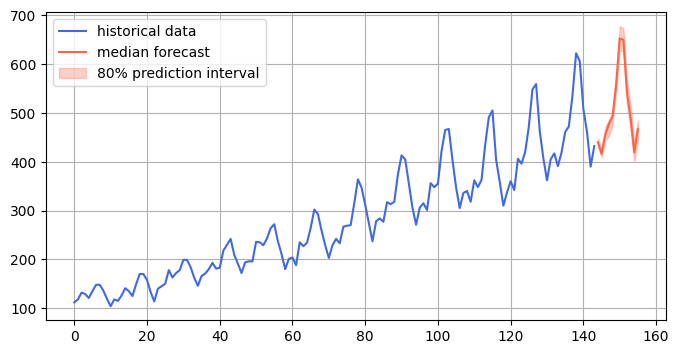

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [8]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
embeddings, tokenizer_state = pipeline.embed(context)

/home/stock_embeddings/miniconda/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
context.shape, embeddings.shape

(torch.Size([144]), torch.Size([1, 145, 512]))

# our data example

In [16]:
with open('configs/best_stocks_nans_rate.yaml') as f:
    best_stocks = yaml.load(f, Loader=yaml.FullLoader)
best_stocks = list(best_stocks.keys())

In [17]:
df = read_data('data/all_tickers.csv')
df_best = df.query("Stock in @best_stocks")
df_best.head()

,Date,Time,Open,High,Low,Close,Volume,Datetime,Stock,Day_week
61,2024-01-30,22:58:00,188.13,188.17,188.110,188.14,1500,2024-01-30 22:58:00,AAPL,Tuesday
62,2024-01-30,22:57:00,188.22,188.22,188.080,188.11,5700,2024-01-30 22:57:00,AAPL,Tuesday
63,2024-01-30,22:56:00,188.22,188.27,188.215,188.22,2600,2024-01-30 22:56:00,AAPL,Tuesday
64,2024-01-30,22:55:00,188.15,188.20,188.140,188.20,2100,2024-01-30 22:55:00,AAPL,Tuesday
65,2024-01-30,22:54:00,188.18,188.18,188.140,188.18,2013,2024-01-30 22:54:00,AAPL,Tuesday


In [ ]:
col_agg_finctions = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}

df_agg = df_best.set_index('Datetime').groupby(
    ['Stock', pd.Grouper(freq='h')],
).agg(col_agg_finctions)

df_agg